In [1]:
import sys
sys.path.append('../')

from lift.datasets import (
    load_all_mad_datasets,
    compute_features,
    mad_labels_to_actions,
    weighted_augmentation,
)

from configs import BaseConfig

In [2]:
from lift.datasets import get_samples_per_group

In [3]:
import torch
import random

class WeightedInterpolator:
    def __init__(self, features, actions, k=None, sample=False):
        self.features = features
        self.actions = actions
        self.epsilon = 1e-5
        self.k = k
        self.sample = sample

        self.unique_actions = torch.unique(actions, dim=0)

        # get mapping from unique indices to action indices
        self.u_act_to_actions = {}
        for i, u_act in enumerate(self.unique_actions):
            u_act_idxs = torch.argwhere((actions==u_act).all(dim=1))
            self.u_act_to_actions[i] = u_act_idxs.squeeze()

        assert actions.shape[0] == sum([x.shape[0] for x in self.u_act_to_actions.values()]), 'Number of action missmatch'

    def __call__(self, new_actions):
        if not isinstance(new_actions, torch.Tensor):
            new_actions = torch.tensor(new_actions, dtype=torch.float32)

        # Step 1: Calculate distances for each new action for all actions and unique actions
        unique_distances = torch.norm(self.unique_actions - new_actions[:, None, :], dim=2)
        distances = torch.norm(self.actions - new_actions[:, None, :], dim=2)

        # Step 2: Compute interpolation weights
        weights = 1 / (distances + self.epsilon)
        weights /= weights.sum(axis=1, keepdims=True)

        unique_weights = 1 / (unique_distances + self.epsilon)
        unique_weights /= unique_weights.sum(axis=1, keepdims=True)

        # Step 3: Ensure uniqueness of sampled actions
        if self.k is not None:
            if self.sample:
                indices = torch.multinomial(unique_weights, self.k, replacement=False)
            else:
                indices = torch.topk(unique_weights, k=5, dim=1).indices

            sampled_indices = torch.tensor([[random.choice(self.u_act_to_actions[val.item()]) for val in row] for row in indices])

            mask = torch.zeros(new_actions.shape[0], self.actions.shape[0])
            mask.scatter_(1, sampled_indices, 1)

            sampled_weights = weights * mask
            sampled_weights /= sampled_weights.sum(dim=1, keepdim=True)

            weights = sampled_weights

        # Step 4: Interpolate features
        interpolated_features_batch = torch.tensordot(weights, self.features, dims=([1],[0]))

        return interpolated_features_batch
    

def weighted_augmentation(mad_windows, mad_actions, config):
    mad_features = compute_features(mad_windows, feature_list = ['MAV'])
    interpolator = WeightedInterpolator(mad_features, mad_actions,
                                        k=config.simulator.k,
                                        sample=config.simulator.sample)

    if config.pretrain.augmentation_distribution == 'uniform':
        sample_actions = torch.rand(config.pretrain.num_augmentation,
                                    config.action_size) * 2 - 1
    elif config.pretrain.augmentation_distribution == 'normal':
        sample_actions = torch.normal(0, .5, (config.pretrain.num_augmentation,
                                                config.action_size)).clip(-1, 1)

    sample_features = interpolator(sample_actions)
    return sample_features, sample_actions

In [21]:
config = BaseConfig()

all_people_list = [f"Female{i}" for i in range(10)] + [f"Male{i}" for i in range(16)]
people_list = [p for p in all_people_list if not p == config.target_person]

person_dataset = {}

for p in people_list:
    other_list = [o_p for o_p in all_people_list if not o_p == p]

    mad_windows, mad_labels, _ = load_all_mad_datasets(
        config.mad_base_path.as_posix(),
        num_channels=config.num_channels,
        emg_range=config.emg_range,
        window_size=config.window_size,
        window_overlap=config.window_overlap,
        desired_labels=config.desired_mad_labels,
        # skip_person=config.target_person,
        skip_person=other_list,
        return_tensors=True,
        verbose=False,
        cutoff_n_outer_samples=0,
    )

    mad_features = compute_features(mad_windows, feature_list=['MAV'])
    mad_actions = mad_labels_to_actions(
        mad_labels, recording_strength=config.simulator.recording_strength,
    )

    config.pretrain.num_augmentation = 1_000
    config.simulator.k = 3
    config.simulator.sample = False

    # this prevents augmentation to pick samples from the same action
    # mad_windows_aug, mad_labels_aug = get_samples_per_group(mad_windows, mad_labels, 2)
    # mad_actions_aug = mad_labels_to_actions(
    #     mad_labels_aug, recording_strength=config.simulator.recording_strength,
    # )
    sample_features, sample_actions = weighted_augmentation(mad_windows, mad_actions, config)
    # sample_features, sample_actions = weighted_augmentation(mad_windows_aug, mad_actions_aug, config)

    person_dataset[p] = {
        'features': mad_features,
        'aug_features': sample_features,
        'aug_actions': sample_actions,
        'actions': mad_actions,
        'labels': mad_labels
    }
    # break
# check out mean MAV and std per action

In [22]:
import matplotlib.pyplot as plt
import torch
import umap

In [23]:
all_feats = []
all_actions = []
for s in person_dataset.values():    
    f = s['features']
    aug_f = s['aug_features']
    aug_a = s['aug_actions']
    a = s['actions']
    
    p_f = torch.cat([f, aug_f], dim=0)
    p_a = torch.cat([a, aug_a], dim=0)

    all_feats.append(p_f)
    all_actions.append(p_a)

all_feats = torch.cat(all_feats, dim=0)
all_actions = torch.cat(all_actions, dim=0)

all_feats = (all_feats - all_feats.mean()) / all_feats.std()

In [24]:
all_feats.shape

torch.Size([63230, 8])

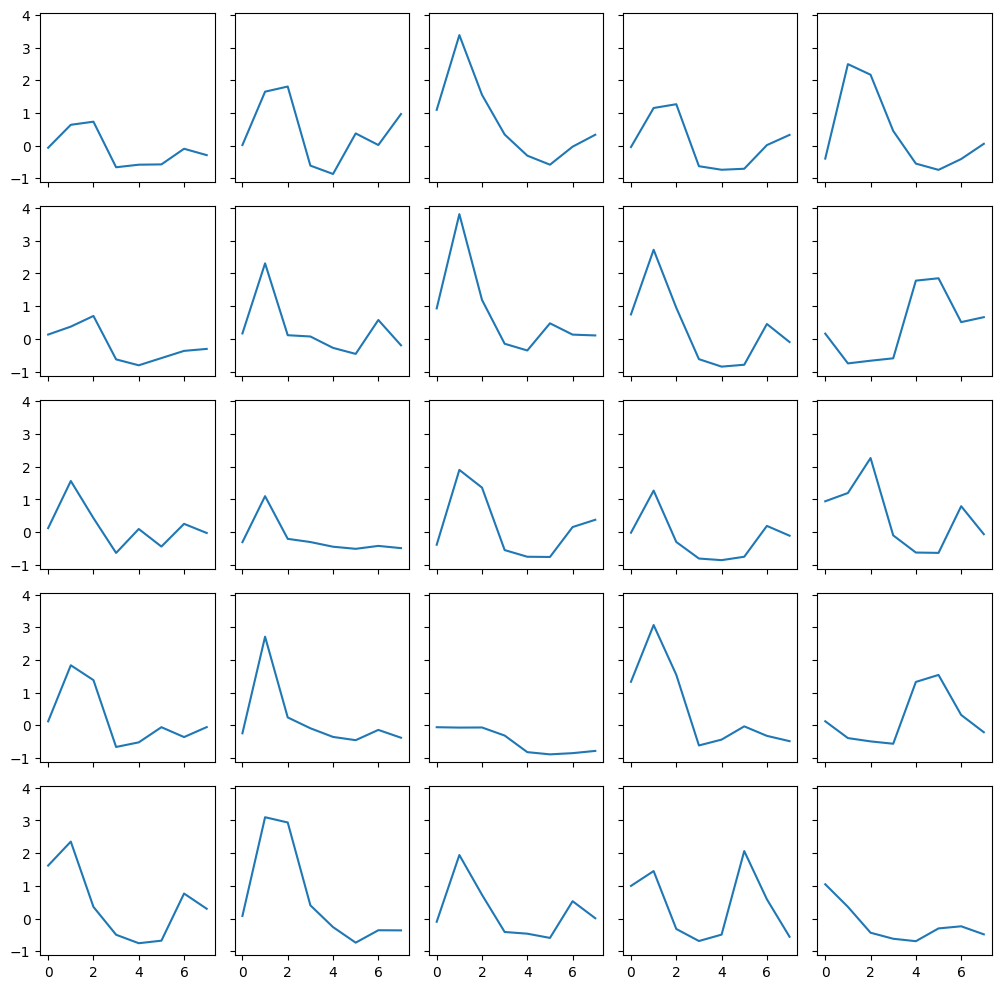

In [10]:
fig, axs = plt.subplots(5, 5, figsize=(10,10), sharex=True, sharey=True)

for i, p_data in enumerate(person_dataset.values()):
    x_idx = i % 5
    y_idx = i // 5
    ax = axs[x_idx, y_idx]

    f = p_data['features']
    a = p_data['actions']
    f = (f - f.mean()) / f.std()
    u_as = a.unique(dim=0)
    u_a = u_as[2]
    f_a = f[(a == u_a).all(dim=1)]

    ax.plot(f_a[0])

plt.tight_layout()

In [11]:
act_dim = all_actions.shape[-1]
reducer = umap.UMAP(
    n_neighbors=50, 
    n_components=2, 
    metric="euclidean", 
    n_jobs=1,
    random_state=0,
)
embeddings = reducer.fit_transform(all_feats)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [12]:
from sklearn.decomposition import KernelPCA

In [13]:
pca = KernelPCA(n_components=3).fit(all_feats.numpy())
pca_pred = pca.transform(all_feats.numpy())

In [14]:
def scatter_plot_embeddings(embeddings, c, title, ax, cmap="coolwarm", vmin=-1., vmax=1., s=4):
    ax.scatter(embeddings[:, 0], embeddings[:, 1], c=c, cmap=cmap, vmin=vmin, vmax=vmax, s=4)
    ax.set_title(title)
    return ax

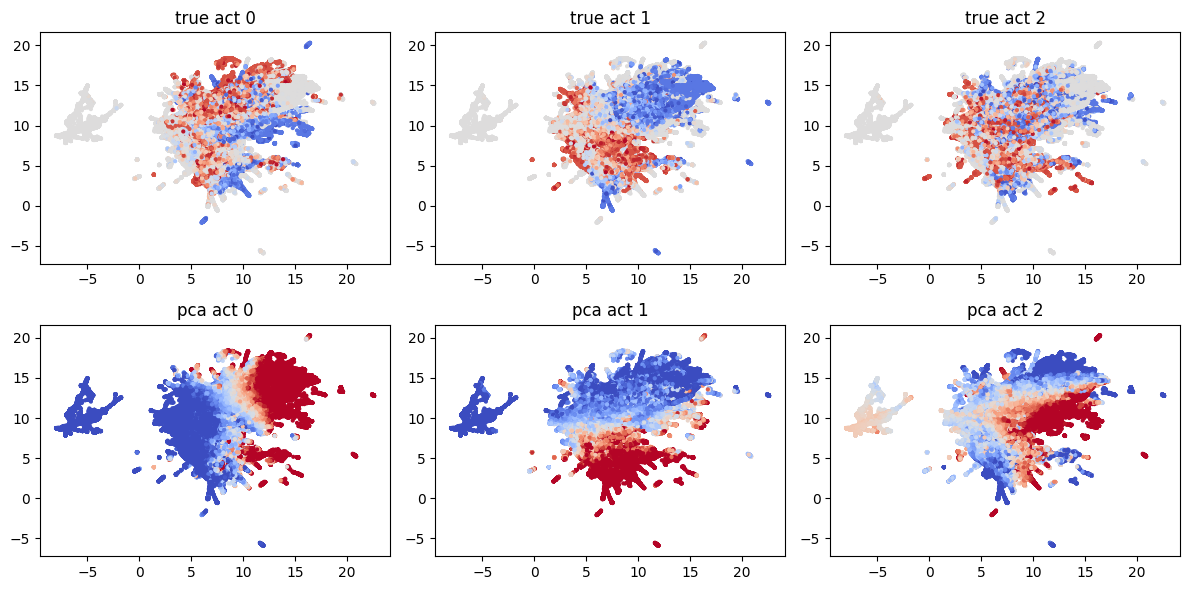

In [15]:
# visualize
fig, ax = plt.subplots(2, act_dim, figsize=(4 * act_dim, 6))
for i in range(act_dim):
    scatter_plot_embeddings(embeddings, all_actions[:, i], f"true act {i}", ax[0, i])
    scatter_plot_embeddings(embeddings, pca_pred[:, i], f"pca act {i}", ax[1, i])
plt.tight_layout()
plt.show()

In [74]:
reducer = umap.UMAP(
    n_neighbors=50, 
    n_components=2, 
    metric="euclidean",
    n_jobs=1,
    random_state=0,
)

embs_list = []
all_a_list = []  

for i, p_data in enumerate(person_dataset.values()):
    f = p_data['features']
    aug_f = p_data['aug_features']
    aug_a = p_data['aug_actions']
    a = p_data['actions']
    l = p_data['labels']

    all_f = torch.cat([f, aug_f], dim=0)
    all_a = torch.cat([a, aug_a], dim=0)

    embs = reducer.fit_transform(all_f)

    embs_list.append(embs)
    all_a_list.append(all_a)

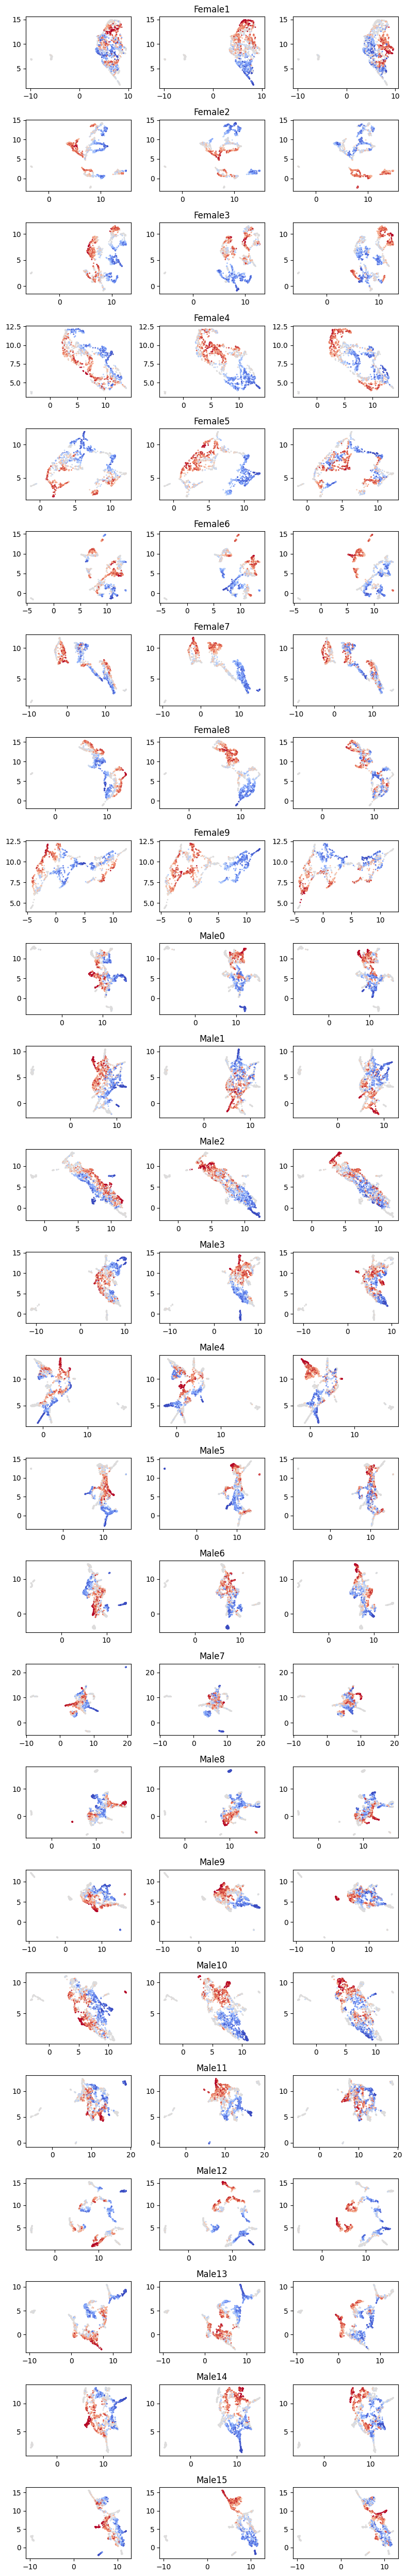

In [82]:
fig, axs = plt.subplots(len(person_dataset), 3, figsize=(8,50))
p_labels = list(person_dataset.keys())

for i, (embs, all_a) in enumerate(zip(embs_list, all_a_list)):
    c = all_a[:,0]
    # c[c.abs() == 0.8] *= 1.3
    axs[i, 0].scatter(embs[:,0], embs[:,1], c=c, s=1., cmap="coolwarm")
    c = all_a[:,1]
    # c[c.abs() == 0.8] *= 1.3
    axs[i, 1].scatter(embs[:,0], embs[:,1], c=c, s=1., cmap="coolwarm")
    c = all_a[:,2]
    # c[c.abs() == 0.8] *= 1.3
    axs[i, 2].scatter(embs[:,0], embs[:,1], c=c, s=1., cmap="coolwarm")
    axs[i, 1].set_title(p_labels[i])

plt.tight_layout()

In [16]:
import wandb

from lift.controllers import BCTrainer, MITrainer
from lift.environments.gym_envs import NpGymEnv
from lift.datasets import get_dataloaders
from lift.teacher import load_teacher

from pytorch_lightning.loggers import WandbLogger
import lightning as L

/opt/homebrew/anaconda3/envs/lift/lib/python3.11/site-packages/torchrl/data/replay_buffers/samplers.py:37: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. If you installed TorchRL from PyPI, please report the bug on TorchRL github. If you installed TorchRL locally and/or in development mode, check that you have all the required compiling packages.
  warnings.warn(EXTENSION_WARNING)
/opt/homebrew/anaconda3/envs/lift/lib/python3.11/site-packages/lightning_fabric/__init__.py:41: Deprecated call to `pkg_resources.declare_namespace('lightning_fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
/opt/homebrew/anaconda3/envs/lift/lib/python3.11/site-packages/pytorch_lightning/__init__.py:37: Deprecated call to `pkg_resources.declare_namespac

In [17]:
env = NpGymEnv(
    "FetchReachDense-v2",
    cat_obs=True,
    cat_keys=config.teacher.env_cat_keys,
)

In [25]:
all_feats.shape, all_actions.shape

(torch.Size([63230, 8]), torch.Size([63230, 3]))

In [19]:
import torch.nn as nn

In [26]:
config.encoder.hidden_size = 1024
config.encoder.n_layers = 6
config.encoder.dropout = 0.1
config.pretrain.weight_decay = 0.0
config.pretrain.lr = 3e-4
config.pretrain.target_std = 0.2

model = BCTrainer(config, env, activation=nn.ReLU)
logger = WandbLogger(project='lift_test')

sl_data_dict = {
    "emg_obs": all_feats,
    "act": all_actions,
}
train_dataloader, val_dataloader = get_dataloaders(
    data_dict=sl_data_dict,
    train_ratio=config.pretrain.train_ratio,
    batch_size=config.pretrain.batch_size,
    num_workers=config.num_workers,
)

trainer = L.Trainer(
    max_epochs=100, 
    log_every_n_steps=1, 
    check_val_every_n_epoch=1,
    enable_checkpointing=False, 
    gradient_clip_val=config.gradient_clip_val,
    logger=logger,
)
trainer.fit(
    model=model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=val_dataloader,
)

wandb.run.finish()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/anaconda3/envs/lift/lib/python3.11/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore



  | Name    | Type                | Params
------------------------------------------------
0 | encoder | TanhGaussianEncoder | 5.3 M 
------------------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params
21.053    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/anaconda3/envs/lift/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▄▅▄▄▄▄▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▆▅▄▄▄▄▄▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁
train_std,▆▃▆▅▅▅█▃▅▁▅▇▅▆▆▅▅▆▆▅▅▆▅▆▅▄▅▆▆▆▅▆▆▅▆▅▅▅▅▅
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_std,██▇▄▆█▃▇▆▆▃▃▃▃▂▅▄▁▃▆▄▄▃▅▅▄▄▃▅▅▄▅▃▄▆▄▃▂▃▃
epoch,67
train_loss,0.00722
train_mae,0.06893


In [12]:
batch = next(iter(val_dataloader))

In [13]:
pred = model.encoder.sample(batch['emg_obs'])
y = batch['act']

In [14]:
pred.abs().sum(-1).max()

tensor(2.3645, grad_fn=<MaxBackward1>)

In [41]:
(pred - y).abs().mean()

tensor(0.1734, grad_fn=<MeanBackward0>)

In [15]:
batch

{'emg_obs': tensor([[-0.6814,  0.3880,  0.1969,  ...,  1.2455, -0.2047, -0.9491],
         [-0.2441,  0.1538, -0.3177,  ...,  3.0622,  1.2254,  0.3545],
         [-0.3951,  0.0467, -0.6256,  ...,  0.4535,  1.8880,  0.7859],
         ...,
         [ 1.2075,  0.4505, -0.5579,  ..., -0.6747,  0.0556,  0.0370],
         [ 0.1815,  1.1078,  0.4478,  ..., -1.0316, -0.5894, -0.7073],
         [ 3.1887,  2.8704,  1.0900,  ...,  0.2802,  0.7665,  0.7189]]),
 'act': tensor([[ 0.8000,  0.0000,  0.0000],
         [ 0.0000,  0.8000,  0.0000],
         [ 0.0000,  0.8000,  0.0000],
         ...,
         [-0.8000,  0.0000,  0.0000],
         [ 0.0748, -0.4827, -0.4677],
         [-0.8000,  0.0000,  0.0000]])}

In [84]:
config.mi.beta_1 = .005 # mi weight, use 0.5 for mse
config.mi.beta_2 = 0.0 # kl weight
config.mi.beta_3 = 1.0 # sl weight

config.encoder.hidden_size = 512
config.encoder.n_layers = 4
config.encoder.dropout = 0.1

model = MITrainer(config, env, supervise=True)

logger = WandbLogger(project='lift_test', config=config.model_dump())

sl_data_dict = {
    "emg_obs": all_feats,
    "sl_act": all_actions,
}
train_dataloader, val_dataloader = get_dataloaders(
    data_dict=sl_data_dict,
    train_ratio=config.pretrain.train_ratio,
    batch_size=config.pretrain.batch_size,
    num_workers=config.num_workers,
)

trainer = L.Trainer(
    max_epochs=200, 
    log_every_n_steps=1, 
    check_val_every_n_epoch=1,
    enable_checkpointing=False, 
    gradient_clip_val=config.gradient_clip_val,
    logger=logger,
)
trainer.fit(
    model=model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=val_dataloader,
)

wandb.run.finish()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kilian. Use `wandb login --relogin` to force relogin
/opt/homebrew/anaconda3/envs/lift/lib/python3.11/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore



  | Name    | Type                | Params
------------------------------------------------
0 | encoder | TanhGaussianEncoder | 795 K 
1 | critic  | MLP                 | 794 K 
------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.361     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/anaconda3/envs/lift/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/act_mae,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/entropy,█▇▇▆▆▆▆▆▅▄▄▄▄▄▃▄▃▄▃▂▃▂▃▃▃▂▃▁▂▂▃▂▁▁▂▂▁▁▁▁
train/log_post,▇▇▇▇▇▇▇▇███████████████████▇███▇▆▇██▆▁▇▇
train/log_prior,█▆▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▂▁▁▁
train/loss,█▆▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,█▆▅▅▄▄▄▃▃▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁
train/mae_prior,▁▃▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▆▆▆▇▇▇▇▇▇▇▇▇██▇▇▇██▇█▇▇
train/mi_accuracy,▁▄▄▃▄▅▅▆▆▇▆▆▆▇▆▆▇▇▇▇▇▇▇██▇█▇█▇▇▇▇▇█▇▇▇▇▇
train/mi_loss,█▄▄▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/missalignment_mae,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
